In [1]:
from aberration.model import PhaseNet, Config, Data
from phasenet.zernike import ZernikeWavefront
from csbdeep.utils import normalize, download_and_extract_zip_file
import matplotlib.pyplot as plt
from pathlib import Path
from tifffile import imread
import numpy as np
from sklearn import metrics

import tifffile as tiff
from pathlib import Path
from skimage.transform import rescale


Using TensorFlow backend.
C:\Users\vinograd\Anaconda3_12\envs\phasenet4\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\vinograd\Anaconda3_12\envs\phasenet4\lib\site-packages\tensorflow\python\framework\dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\vinograd\Anaconda3_12\envs\phasenet4\lib\site-packages\tensorflow\python\framework\dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\vinograd

GPU Tools False


In [2]:
zern = [3,5,6,7,8,9,10,11,12,13,14]
amp_range = 0.075
amps = dict(zip(zern, [amp_range]*len(zern)))
ph_basedir = 'images/'
c = Config(zernike_amplitude_ranges=amps, psf_na_detection=1.4, psf_units=(0.2,0.068519,0.068519), 
           psf_n=1.5, psf_lam_detection=0.488, 
           crop_shape=(32,32,32), 
           noise_mean=[5,7], noise_snr=[21,34], noise_sigma=[1.5,3], 
           zernike_order='ansi', jitter = True,
           train_batch_size=2,train_steps_per_epoch=5,
           train_epochs=5, # quick test
           train_learning_rate= 0.0003,
           # How to use multiple phantoms:
           phantom_params = {'name':'images','filepath':[ph_basedir+'ly17_crop50.tif',ph_basedir+'ly22_crop50.tif']}
           # To pass a single image as phantom: phantom_params = {'name':'images','filepath':'your_str_path'}
          )


In [4]:

data = Data(
    batch_size           = 5,
    amplitude_ranges     = c.zernike_amplitude_ranges,
    phantom_params       = c.phantom_params,

)
psfs, amps = next(data.generator())

C:\Users\vinograd\AppData\Roaming\Python\Python36\site-packages\phasenet\psf.py:49: RuntimeWarning: invalid value encountered in sqrt
  H = np.sqrt(1. * self.n ** 2 - KR3 ** 2 * lam_detection ** 2)


In [5]:
psfs.shape

(5, 50, 50, 50, 1)

In [4]:
dir_name = './experiments/dual_ly17_ly22_5ep'
model = PhaseNet( config=c, #None,
                 name=dir_name, basedir='')
import json
with open(dir_name+'/config.txt', 'w+') as file:
    file.write(json.dumps(vars(c))) 



C:\Users\vinograd\AppData\Roaming\Python\Python36\site-packages\csbdeep\models\base_model.py:149: UserWarning: output path for model already exists, files may be overwritten: C:\Users\vinograd\Documents\GitHub\aberration\experiments\dual_ly17_ly22_5ep
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


In [7]:
%%time
model.train()

C:\Users\vinograd\AppData\Roaming\Python\Python36\site-packages\phasenet\psf.py:49: RuntimeWarning: invalid value encountered in sqrt
  H = np.sqrt(1. * self.n ** 2 - KR3 ** 2 * lam_detection ** 2)


Epoch 1/5
5/5 [==============================] - 2s 431ms/step - loss: 0.0043 - val_loss: 0.0030
Epoch 2/5
5/5 [==============================] - 1s 294ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 3/5
5/5 [==============================] - 2s 327ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 4/5
5/5 [==============================] - 2s 318ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 5/5
5/5 [==============================] - 2s 324ms/step - loss: 0.0021 - val_loss: 0.0019

Loading network weights from 'weights_best.h5'.
Wall time: 34.8 s


"plt.figure(figsize=(10,8))\nplt.plot(history['acc'], marker='*', label='acc')\nplt.plot(history['val_acc'], '--', marker='*', label='val_acc')\nplt.xlabel('epoch')\nplt.ylabel('acc')\n#plt.yscale('log')\nplt.legend()\nplt.title(f'Accuracy ')\nplt.savefig(dir_name+'acc_'+'.png')"

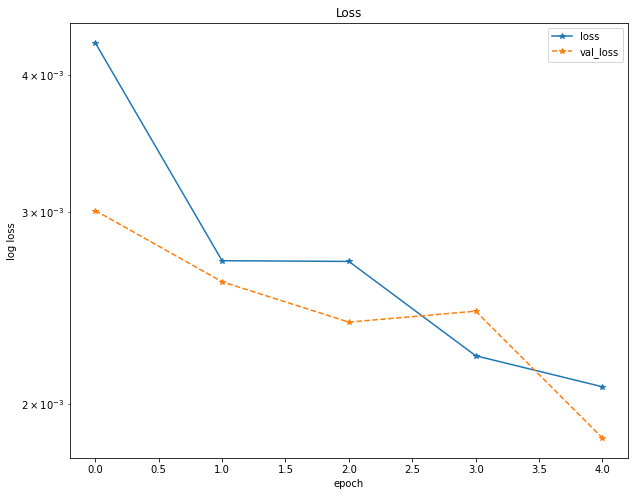

In [8]:
history = model.keras_model.history.history

fig= plt.figure(figsize=(10,8))
plt.plot(history['loss'], marker='*', label='loss')
plt.plot(history['val_loss'], '--', marker='*', label='val_loss')
plt.xlabel('epoch')
#ax.set_xticks(ax.get_xticks()[::2])
#plt.set_xticks(plt.get_xticks()+50000)
#plt.xticks(fig.get_xticks(), #range(0, int(len(history['loss'])/5000)+1),
#           list(str(i*5000+50000) for i in range(0, int(len(history['loss'])/5000)+1)))#, zern_ansi, fontsize=fontsize_small)
plt.ylabel('log loss')
plt.yscale('log')
plt.legend()
plt.title(f'Loss')
plt.savefig(dir_name+'/loss_'+'.png')

"""plt.figure(figsize=(10,8))
plt.plot(history['acc'], marker='*', label='acc')
plt.plot(history['val_acc'], '--', marker='*', label='val_acc')
plt.xlabel('epoch')
plt.ylabel('acc')
#plt.yscale('log')
plt.legend()
plt.title(f'Accuracy ')
plt.savefig(dir_name+'acc_'+'.png')"""

In [5]:
amps = dict(zip([7], [0.005]))

data = Data(
        batch_size           = 5,
        amplitude_ranges     = amps,
        order                = model.config.zernike_order,
        normed               = model.config.zernike_normed,
        psf_shape            = model.config.psf_shape,
        units                = model.config.psf_units,
        na_detection         = model.config.psf_na_detection,
        lam_detection        = model.config.psf_lam_detection,
        n                    = model.config.psf_n,
        noise_mean           = model.config.noise_mean,
        noise_snr            = model.config.noise_snr,
        noise_sigma          = model.config.noise_sigma,
        noise_perlin_flag    = model.config.noise_perlin_flag,
        crop_shape           = model.config.crop_shape,
        jitter               = False,
        phantom_params       = model.config.phantom_params,
        planes               = model.config.planes,
    )
psfs, amps = next(data.generator())

C:\Users\vinograd\AppData\Roaming\Python\Python36\site-packages\phasenet\psf.py:49: RuntimeWarning: invalid value encountered in sqrt
  H = np.sqrt(1. * self.n ** 2 - KR3 ** 2 * lam_detection ** 2)


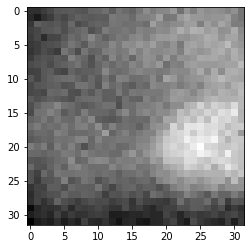

In [11]:
plt.imshow(psfs[3,19],cmap='gray')
#contrast can be tuned for better visualization
plt.savefig("output_images/synthetic_example.png")